# Practical work on high resolution methods
## CAPITAN Guillaume, MOALIC Baptiste
### TSIA202b

In [1]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [8]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [3]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [4]:
IPython.display.Audio('ClocheB.WAV')

In [5]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

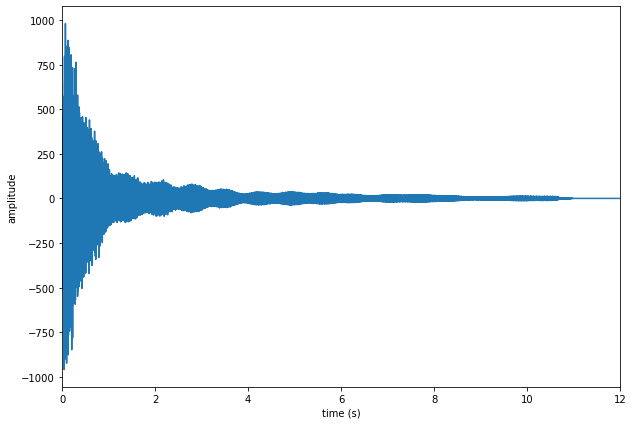

In [6]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [27]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

#### <span style="color:red">3.1</span> Spectral analysis by Fourier transform

In [9]:
#Synthesis of the signal
N = 63
f0 = 1/4

s = Synthesis(N, np.array([0, -0.05]), np.array([f0, f0+1/N]), np.array([1, 10]), np.random.uniform(-np.pi, np.pi, (1,2)))

In [11]:
#Importing the periodogram function from the last practical session
def periodogram(X, nu):
    N = np.size(X)
    #Considering the case where N=0
    if N==0:
        return 0
    #Normal calculation
    res = 0
    for k in range(N):
        res+= X[k]*np.exp(-2*1j*np.pi*nu*k)
    return (1/N)*((np.abs(res))**2)

Text(0.5, 1.0, 'Periodograms of the signal')

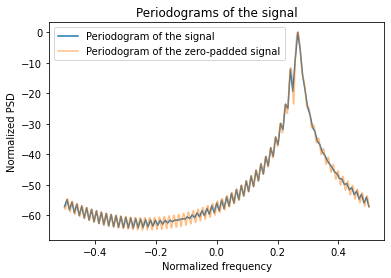

In [24]:
#Plotting the periodogram
zeros_to_add = 1024-N
s_zp = np.append(s, np.zeros((1, zeros_to_add)))

frequencies_1 = np.linspace(-0.5, 0.5, (2*np.size(s))-1)
frequencies_2 = np.linspace(-0.5, 0.5, (2*np.size(s_zp))-1)

periodogram_1 = periodogram(s, frequencies_1)
periodogram_1 = periodogram_1/np.amax(periodogram_1)

periodogram_2 = periodogram(s_zp, frequencies_2)
periodogram_2 = periodogram_2/np.amax(periodogram_2)

plt.plot(frequencies_1, 20*np.log10(periodogram_1), label='Periodogram of the signal')
plt.plot(frequencies_2, 20*np.log10(periodogram_2), alpha=0.5, label='Periodogram of the zero-padded signal')
plt.xlabel('Normalized frequency')
plt.ylabel('Normalized PSD')
plt.legend()
plt.title('Periodograms of the signal')

In both case it is quite hard to distinguish the two frequencies. The zero-padded signal seems to have more resolution, even though it adds more ripples than the original signal.

#### <span style="color:red">3.2.1</span> Computation of the empirical covariance matrix

In [74]:
#Let's synthesize a new signal with noise
random_phase = np.random.uniform(-np.pi, np.pi, (1,2))
s_b = s = Synthesis(N, np.array([0, -0.05]), np.array([f0, f0+1/N]), np.array([1, 10]), random_phase, RSB=20)

In [75]:
#Computing of the Hankel X matrix
n = 32
K = 2
l = N-n+1

X = hankel(s_b[:n], s_b[:l])

In [76]:
#Empirical covariance matrix
Rxx = (1/l)*(X @ X.conj().T)
print('Rxx is of shape '+str(Rxx.shape))

Rxx is of shape (32, 32)


#### <span style="color:red">3.2.2</span> Estimation of the signal subspace

In [77]:
#Diagonalization
[U1,Lambda,U2] = np.linalg.svd(Rxx)
print('U1 is of shape '+str(U1.shape))
print('Lambda is of shape '+str(Lambda.shape))
print('U2 is of shape '+str(U2.shape))

U1 is of shape (32, 32)
Lambda is of shape (32,)
U2 is of shape (32, 32)


In [78]:
#Let's extract the basis of the signal sub-space
W = U1[:n,:K]
print('W is of shape '+str(W.shape))

W is of shape (32, 2)


#### <span style="color:red">3.2.1.3</span> Estimation of the frequencies and damping factors

In [79]:
#Computing of W_up and W_down
W_up = W[:-1,:]
W_down = W[1:,:]
print('W_up is of shape '+str(W_up.shape))
print('W_down is of shape '+str(W_down.shape))

W_up is of shape (31, 2)
W_down is of shape (31, 2)


In [80]:
#Computing of Phi
Phi = np.linalg.pinv(W_down) @ W_up
print('Phi is of shape '+str(Phi.shape))

Phi is of shape (2, 2)


In [81]:
#Estimation of the dampling factors and frequencies
Eigenvalues = np.linalg.eig(Phi)[0]
print('The eigenvalues are: '+str(Eigenvalues))

The eigenvalues are: [-0.05177285-1.00007835j -0.24638672-0.97049151j]


In [82]:
delta_est = np.log(np.abs(Eigenvalues))
f_est = np.abs((1/(2*np.pi))*np.angle(Eigenvalues))

#### <span style="color:red">4</span> Estimation of the amplitudes and phases

In [83]:
#We start by creating a function to compute the Vandermonde matrix with the right shape
def Vandermonde_matrix(eig, N):
    K = np.size(eig)
    res = np.zeros((N,K))
    for j in range(K):
        eig_inter = eig[j]
        for i in range(N):
            res[i,j] = eig_inter**i
    return res

In [84]:
#Estimated amplitude and phase
V_n = Vandermonde_matrix(Eigenvalues, N)
alpha_est = np.linalg.pinv(V_n) @ s_b
a_est = np.abs(alpha_est)
phase_est = np.angle(alpha_est)

<ipython-input-83-b236b40529d2>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  res[i,j] = eig_inter**i


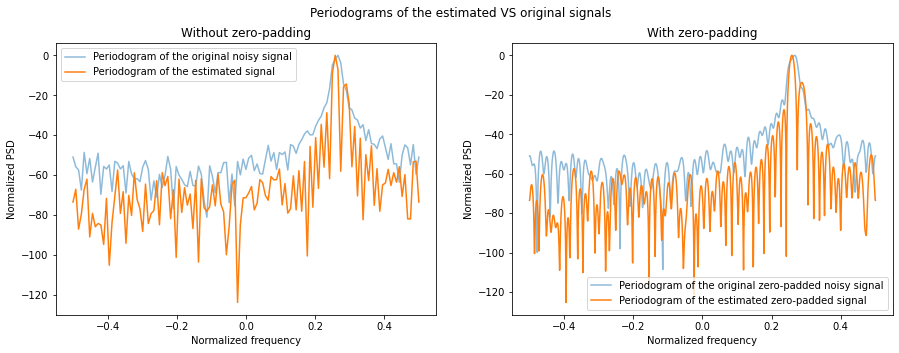

In [85]:
#Let's verify our estimation
s_b_est = Synthesis(N, delta_est, f_est, a_est, phase_est, RSB=20)

#Plotting the periodograms
frequencies = np.linspace(-0.5, 0.5, (2*np.size(s_b_est))-1)

periodogram_1 = periodogram(s_b, frequencies)
periodogram_1 = periodogram_1/np.amax(periodogram_1)

periodogram_2 = periodogram(s_b_est, frequencies)
periodogram_2 = periodogram_2/np.amax(periodogram_2)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(frequencies, 20*np.log10(periodogram_1), alpha=0.5, label='Periodogram of the original noisy signal')
plt.plot(frequencies, 20*np.log10(periodogram_2), label='Periodogram of the estimated signal')
plt.xlabel('Normalized frequency')
plt.ylabel('Normalized PSD')
plt.legend()
plt.title('Without zero-padding')

#Zero-padded version
zeros_to_add = 1024-N
s_b_zp = np.append(s_b, np.zeros((1, zeros_to_add)))
s_b_est_zp = np.append(s_b_est, np.zeros((1, zeros_to_add)))

frequencies = np.linspace(-0.5, 0.5, (2*np.size(s_b_zp))-1)

periodogram_1 = periodogram(s_b_zp, frequencies)
periodogram_1 = periodogram_1/np.amax(periodogram_1)

periodogram_2 = periodogram(s_b_est_zp, frequencies)
periodogram_2 = periodogram_2/np.amax(periodogram_2)

plt.subplot(122)
plt.plot(frequencies, 20*np.log10(periodogram_1), alpha=0.5, label='Periodogram of the original zero-padded noisy signal')
plt.plot(frequencies, 20*np.log10(periodogram_2), label='Periodogram of the estimated zero-padded signal')
plt.xlabel('Normalized frequency')
plt.ylabel('Normalized PSD')
plt.legend()
plt.title('With zero-padding')

plt.suptitle('Periodograms of the estimated VS original signals')
plt.show()

As we can observe on the graph, the estimated model enables us to obtain a better frequency resolution.

In [87]:
print('Original frequencies: '+str([f0, f0+1/N])+' VS Estimated frequencies: '+str(f_est))

"""
print('Original Delta: '+str([0, -0.05])+' VS Estimated Delta: '+str(delta_est))

print('Original amplitudes: '+str([1, 10])+' VS Estimated amplitudes: '+str(a_est))

print('Original phase: '+str(random_phase)+' VS Estimated phase: '+str(phase_est))
"""

Original frequencies: [0.25, 0.26587301587301587] VS Estimated frequencies: [0.25823191 0.28956997]


"\nprint('Original Delta: '+str([0, -0.05])+' VS Estimated Delta: '+str(delta_est))\n\nprint('Original amplitudes: '+str([1, 10])+' VS Estimated amplitudes: '+str(a_est))\n\nprint('Original phase: '+str(random_phase)+' VS Estimated phase: '+str(phase_est))\n"